<h1> Parameter Tunning 
    
    Look at different steps & batch sizes 
    (6 months of data used)

# Importing libraries:

In [13]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt
import time

# months to evaluate model on
date = 2018090000

# for later use
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import data; fill nan values; split data intro train and test:

In [14]:
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values in the whole data set
data.fillna(data.mean(), inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [15]:
from sklearn.preprocessing import MinMaxScaler

# data scaling
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

# Need to process data with spike occurences in the same way as features and offers:
(Required to evaluate predictions in both normal regions and spike regions)

In [17]:
# download data for shaded area
data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# make sure shaded area will correspond to values outputed by LSTM
data.reset_index(drop = True, inplace = True)

# fill_nan is already made - so lets split data into test and train
from sklearn.model_selection import train_test_split

# divide data into train and test 
shade_train, shade_test = train_test_split(
         data, test_size = 0.15, shuffle = False)

# reset index of testing data
shade_test.reset_index(drop = True, inplace = True)

# function to split data into correct shape for RNN
def split_data_shade(shade_test, steps):
    y_spike_occ = list()
    upper_lim = list()
    lower_lim = list()
    for i in range(steps, len(shade_test.index)):
        y_spike_occ.append(shade_test['spike_occurance'][i])
        upper_lim.append(shade_test['spike_upperlim'][i])
        lower_lim.append(shade_test['spike_lowerlim'][i])
    return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

# function to cut data set so it can be divisible by the batch_size
def cut_data_shade(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# Prepare of data according to LSTM needs,  create regressor & tune:

In [18]:
# parameters
# steps = 96
n_hidden = 1
units = 100
# batch_size = 96

from sklearn.model_selection import ParameterGrid

# 48 - day; 96 - 2 days; 336 - 1 week
parameters = {'steps': [48, 96, 336],
              'batch_size': [48, 96, 336]}

all_param = ParameterGrid(parameters)

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

for i in range(len(all_param)):
    
    start_time = time.time()
    
    # set parameters right
    steps = all_param[i]['steps']
    batch_size = all_param[i]['batch_size']
    
    # divide features and labels
    X_train = data_train[:, 0:14] 
    y_train = data_train[:, -1]
    X_test = data_test[:, 0:14] 
    y_test = data_test[:, -1] 

    # divide data into train and test 
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.15, shuffle=False)

    # put data into correct shape
    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)

    X_train = cut_data(X_train, batch_size)
    y_train = cut_data(y_train, batch_size)
    X_test = cut_data(X_test, batch_size)
    y_test = cut_data(y_test, batch_size)
    X_val = cut_data(X_val, batch_size)
    y_val = cut_data(y_val, batch_size)

    def regressor_tunning(kernel_initializer = 'he_uniform',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        if n_hidden == 1:
            model.add(LSTM(units = units,                    
                           batch_input_shape = (batch_size, steps, features_num), 
                           stateful = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units = units,                    
                           batch_input_shape = (batch_size, steps, features_num), 
                           stateful = True,
                           return_sequences = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
            model.add(LSTM(units = units, 
                           batch_input_shape = (batch_size, steps, features_num), 
                           stateful = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        optimizer = optimizers.RMSprop()
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
        return model

    model = regressor_tunning()

    # fitting the LSTM to the training set
    model.fit(X_train,
              y_train, 
              batch_size = batch_size, 
              epochs = 180,
              shuffle = False, 
              validation_data = (X_val, y_val))

    # reset states to have suitable predictions
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    
    # Reshaping
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))
    
    y_pred_list.append(y_pred)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)

    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)

    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    # shape y_spike_occ for the right size to compare results in normal and spike regions
    y_spike_occ, spike_upperlim, spike_lowerlim = split_data_shade(shade_test, steps)
    y_spike_occ = cut_data_shade(y_spike_occ, batch_size)
    
    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)

    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)

    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)

    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)


Train on 4176 samples, validate on 672 samples
Epoch 1/180
4176/4176 [==============================] - 9s 2ms/step - loss: 0.1267 - mse: 0.1267 - mae: 0.2798 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1485
Epoch 2/180
4176/4176 [==============================] - 8s 2ms/step - loss: 0.0452 - mse: 0.0452 - mae: 0.1685 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0280
Epoch 3/180
4176/4176 [==============================] - 8s 2ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.1110 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0734
Epoch 4/180
4176/4176 [==============================] - 8s 2ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0765 - val_loss: 4.0287e-04 - val_mse: 4.0287e-04 - val_mae: 0.0151
Epoch 5/180
4176/4176 [==============================] - 8s 2ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0539 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0308
Epoch 6/180
4176/4176 [==============================] - 8s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.039

# Save results into a data frame

In [19]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count})

In [1]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

NameError: name 'results' is not defined

In [21]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count}, index = all_param)

results.to_csv('Results_LSTM_steps_batch.csv')

y_pred_list = pd.Series(y_pred_list)
y_pred_list.to_csv('Predictions_LSTM_steps_batch.csv')

<IPython.core.display.Javascript object>


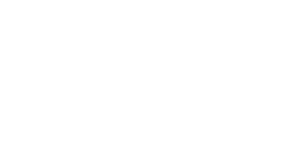

In [22]:
%matplotlib notebook

w_plot = 144 # 3 days
fontsize = 13

y_pred = y_pred.reshape(len(y_pred))

Residual = list(y_test) - y_pred

plt.figure(figsize=(8,3))
plt.plot(np.arange(0, (w_plot)), y_test[-w_plot:], label = 'Real values', linewidth = 1.5, color = 'steelblue')
plt.plot(np.arange(0, (w_plot)), y_pred[-w_plot:], label = 'Predicted values', linewidth = 1.2, color= 'deepskyblue')
plt.plot(np.arange(0, (w_plot)), Residual[-w_plot:], label = 'Residual error', linewidth = 0.8, color = 'slategrey')
plt.fill_between(np.arange(0, (w_plot)),  data['spike_lowerlim'][-w_plot:],data['spike_upperlim'][-w_plot:], facecolor='skyblue', alpha=0.5, label = 'Not spike regions')
plt.xlim(0, w_plot - 1)
plt.ylim(-100, 260)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('Linear Regression predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('LSTM_1_hidden_150_nerons.png')

In [23]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (336, 100)                46000     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (336, 100)                0         
_________________________________________________________________
dropout_15 (Dropout)         (336, 100)                0         
_________________________________________________________________
dense_12 (Dense)             (336, 1)                  101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________


In [24]:
results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
"{'batch_size': 48, 'steps': 48}",28.202711,16.480071,36.249841,23.232468,26.794765,15.471967,1417.845439
"{'batch_size': 48, 'steps': 96}",29.592841,17.300593,39.835471,24.832043,27.669325,16.134068,3031.824494
"{'batch_size': 48, 'steps': 336}",29.910734,18.301353,42.713636,26.054521,26.947436,16.896417,9944.326554
"{'batch_size': 96, 'steps': 48}",30.214591,19.570233,41.101288,26.997672,28.154359,18.419817,1103.011186
"{'batch_size': 96, 'steps': 96}",30.363877,18.799999,45.164562,26.809938,27.364591,17.559362,2101.954840
"{'batch_size': 96, 'steps': 336}",26.341611,17.728731,37.896906,23.929939,23.448946,16.525512,6788.654867
"{'batch_size': 336, 'steps': 48}",28.436635,18.821261,30.600059,20.606691,28.096201,18.552224,865.420199
"{'batch_size': 336, 'steps': 96}",31.929323,24.562494,37.913167,25.740586,30.900710,24.380315,1581.925126
"{'batch_size': 336, 'steps': 336}",28.380255,18.614568,28.808583,20.770103,28.293811,18.183461,4459.053237
